In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')


# 前処理

In [12]:
train_df = pd.read_csv('../data/league-of-legends-winning-predicition/train.csv')
test_df = pd.read_csv('../data/league-of-legends-winning-predicition/test_template.csv')

In [13]:
# 元のデータサイズを保持
original_train_size = len(train_df)
original_test_size = len(test_df)

print(original_train_size, original_test_size)

144000 36000


In [14]:
train_df.drop('timecc', axis=1, inplace=True)
train_df.columns

Index(['id', 'win', 'kills', 'deaths', 'assists', 'largestkillingspree',
       'largestmultikill', 'longesttimespentliving', 'doublekills',
       'triplekills', 'quadrakills', 'pentakills', 'totdmgdealt',
       'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit',
       'totdmgtochamp', 'magicdmgtochamp', 'physdmgtochamp', 'truedmgtochamp',
       'totheal', 'totunitshealed', 'dmgtoturrets', 'totdmgtaken',
       'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'wardsplaced',
       'wardskilled', 'firstblood'],
      dtype='object')

### 外れ値検出
今回はゲームデータなので、外れ値を除去しない方が良いと判断。
Zスコアというものを使うらしい。

$$
z = \frac{(X - \mu)}{\sigma}
$$

標準化の式と同じだが、Zスコアは各データが平均からどれだけ離れているかを示す指標である。

# 特徴量エンジニアリング

In [15]:
# ベースモデル用に+20個ほどの特徴量を作成
def create_features(df):
    df_new = df.copy()

    # ==KDA関連==
    df_new['kda'] = (df['kills'] + df['assists'] + 1) / np.maximum(1, df['deaths'])
    df_new['pure_kill_ratio'] = df['kills'] / np.maximum(1, df['deaths'])

    # ==ダメージ関連==
    df_new['dmg_per_death'] = df['totdmgtochamp'] / np.maximum(1, df['deaths'])
    df_new['dmg_efficiency'] = df['totdmgtochamp'] / np.maximum(1, df['totdmgtaken'])
    df['chmap_dmg_ratio'] = df['totdmgtochamp'] / np.maximum(1, df['totdmgdealt'])

    # ==ダメージ構成==
    df_new['physical_ratio'] = df['physicaldmgdealt'] / np.maximum(1, df['totdmgdealt'])
    df_new['magic_ratio'] = df['magicdmgdealt'] / np.maximum(1, df['totdmgdealt'])

    # ==生存力==
    df_new['survival_rate'] = df['longesttimespentliving'] / np.maximum(1, df['deaths'])
    df_new['tankiness'] = df['totdmgtaken'] / np.maximum(1, df['deaths'])

    # ==回復==
    df_new['healing_efficiency'] = df['totheal'] / np.maximum(1, df['totdmgtaken'])
    
    # === オブジェクト貢献 ===
    df_new['tower_dmg_normalized'] = df['dmgtoturrets'] / np.maximum(1, df['longesttimespentliving'])
    df_new['vision_score'] = df['wardsplaced'] + df['wardskilled'] * 2

    # === キャリー能力 ===
    df_new['multiltikill_score'] = (df['doublekills'] * 2 +
                                    df['triplekills'] * 4 +
                                    df['quadrakills'] * 8 +
                                    df['pentakills'] * 16)
    
    # === 総合指標 ===
    df_new['overall_performance'] = (
        df_new['kda'] * 0.6 +
        np.log1p(df_new['dmgtoturrets']) * 0.2 +
        df_new['largestkillingspree'] * 0.2 +
        df_new['multiltikill_score'] * 0.3
    )

    return df_new

勝敗と最も相関が高い特徴量 TOP 10:
win                    1.000000
overall_performance    0.513406
kda                    0.476613
dmgtoturrets           0.384984
pure_kill_ratio        0.384786
dmg_per_death          0.381620
tankiness              0.325753
largestkillingspree    0.317180
assists                0.304382
kills                  0.263815
dtype: float64
勝敗と最も相関が低い特徴量 TOP 10:
healing_efficiency    0.029231
wardsplaced           0.028539
physical_ratio        0.020188
id                   -0.003736
magic_ratio          -0.019570
truedmgtaken         -0.039506
physdmgtaken         -0.046507
totdmgtaken          -0.074532
magicdmgtaken        -0.091852
deaths               -0.365685
dtype: float64


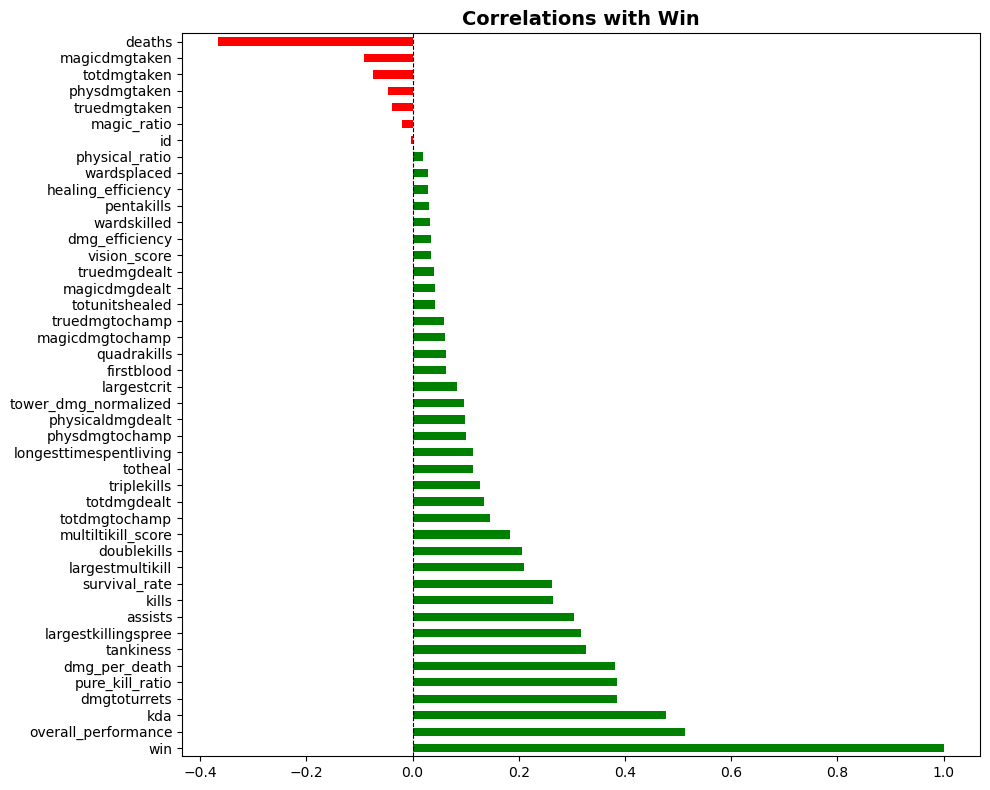

In [16]:
train_df_add_features = create_features(train_df)
test_df_add_features = create_features(test_df)

# 特徴量とターゲットの分割
correlations = train_df_add_features.corrwith(train_df_add_features['win']).sort_values(ascending=False)

print("勝敗と最も相関が高い特徴量 TOP 10:")
print(correlations.head(10))

print("勝敗と最も相関が低い特徴量 TOP 10:")
print(correlations.tail(10))

# 可視化
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=correlations.apply(lambda x: 'green' if x > 0 else 'red'))
plt.title('Correlations with Win', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [17]:
# データの分割とスケーリン
train_x_final = train_df_add_features.drop(['id'], axis=1)
test_x_final = test_df_add_features

# 行数の確認
print(train_x_final.shape, test_x_final.shape)


(144000, 43) (36000, 45)


In [18]:
# それぞれをcsvで保存
save_dir = '../data/processed/'
# ディレクトリが存在しない場合は作成
import os
os.makedirs(save_dir, exist_ok=True)
train_x_final.to_csv(save_dir + 'train_x_add_features.csv', index=False)
test_x_final.to_csv(save_dir + 'test_x_add_features.csv', index=False)